In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d fedesoriano/hepatitis-c-dataset

Dataset URL: https://www.kaggle.com/datasets/fedesoriano/hepatitis-c-dataset
License(s): ODbL-1.0
  0% 0.00/14.8k [00:00<?, ?B/s]
100% 14.8k/14.8k [00:00<00:00, 21.9MB/s]


In [ ]:
!unzip -q hepatitis-c-dataset.zip -d /content/dataset

Import library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import  RandomizedSearchCV, train_test_split , GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from mlxtend.plotting import plot_confusion_matrix
%matplotlib inline
#To turn off warning messages.
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importing the dataset
data = pd.read_csv("dataset/HepatitisCdata.csv")
data.head()

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


In [ ]:
data = data.drop(["Unnamed: 0"], axis = 1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Category  615 non-null    object 
 1   Age       615 non-null    int64  
 2   Sex       615 non-null    object 
 3   ALB       614 non-null    float64
 4   ALP       597 non-null    float64
 5   ALT       614 non-null    float64
 6   AST       615 non-null    float64
 7   BIL       615 non-null    float64
 8   CHE       615 non-null    float64
 9   CHOL      605 non-null    float64
 10  CREA      615 non-null    float64
 11  GGT       615 non-null    float64
 12  PROT      614 non-null    float64
dtypes: float64(10), int64(1), object(2)
memory usage: 62.6+ KB


In [ ]:
#Convert categorical to binary in Category & Sex
data['Category'] = data['Category'].map({'0=Blood Donor': 0,
                                         '0s=suspect Blood Donor': 0,
                                         "1=Hepatitis" : 1,
                                         "2=Fibrosis" : 1,
                                         "3=Cirrhosis" : 1})

data['Sex'] = data['Sex'].map({'m': 0, 'f': 1})

In [ ]:
#EDA
data.isnull().sum()

Category     0
Age          0
Sex          0
ALB          1
ALP         18
ALT          1
AST          0
BIL          0
CHE          0
CHOL        10
CREA         0
GGT          0
PROT         1
dtype: int64

In [ ]:
data.fillna(data.median() ,inplace=True)

In [ ]:
n_cols = {'ALB':'Albumin Blood Test (ALB) g/L ',
            'ALP':  'Alkaline Phosphatase Test (ALP) IU/L',
            'ALT': 'Alanine Transaminase Test (ALT) U/L',
            'AST' : 'Aspartate Transaminase Test (AST) U/L',
            'BIL': 'Bilirubin Blood Test (BIL) µmol/L',
            'CHE' : 'Cholinesterase (CHE) kU/L' ,
            'CHOL' : 'Cholesterol (CHOL) mmol/L',
            'CREA' : 'Creatinine Blod Test (CREA) µmol/L',
            'GGT' : 'Gamma-Glutamyl Transpeptidase Test (GGT) U/L',
            'PROT' : 'Protein Blood Test (PROT) g/L'}

data.rename(columns=n_cols ,inplace=True)
data.head()

,Category,Age,Sex,Albumin Blood Test (ALB) g/L,Alkaline Phosphatase Test (ALP) IU/L,Alanine Transaminase Test (ALT) U/L,Aspartate Transaminase Test (AST) U/L,Bilirubin Blood Test (BIL) µmol/L,Cholinesterase (CHE) kU/L,Cholesterol (CHOL) mmol/L,Creatinine Blod Test (CREA) µmol/L,Gamma-Glutamyl Transpeptidase Test (GGT) U/L,Protein Blood Test (PROT) g/L
0,0,32,0,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,0,32,0,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,0,32,0,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,0,32,0,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,0,32,0,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


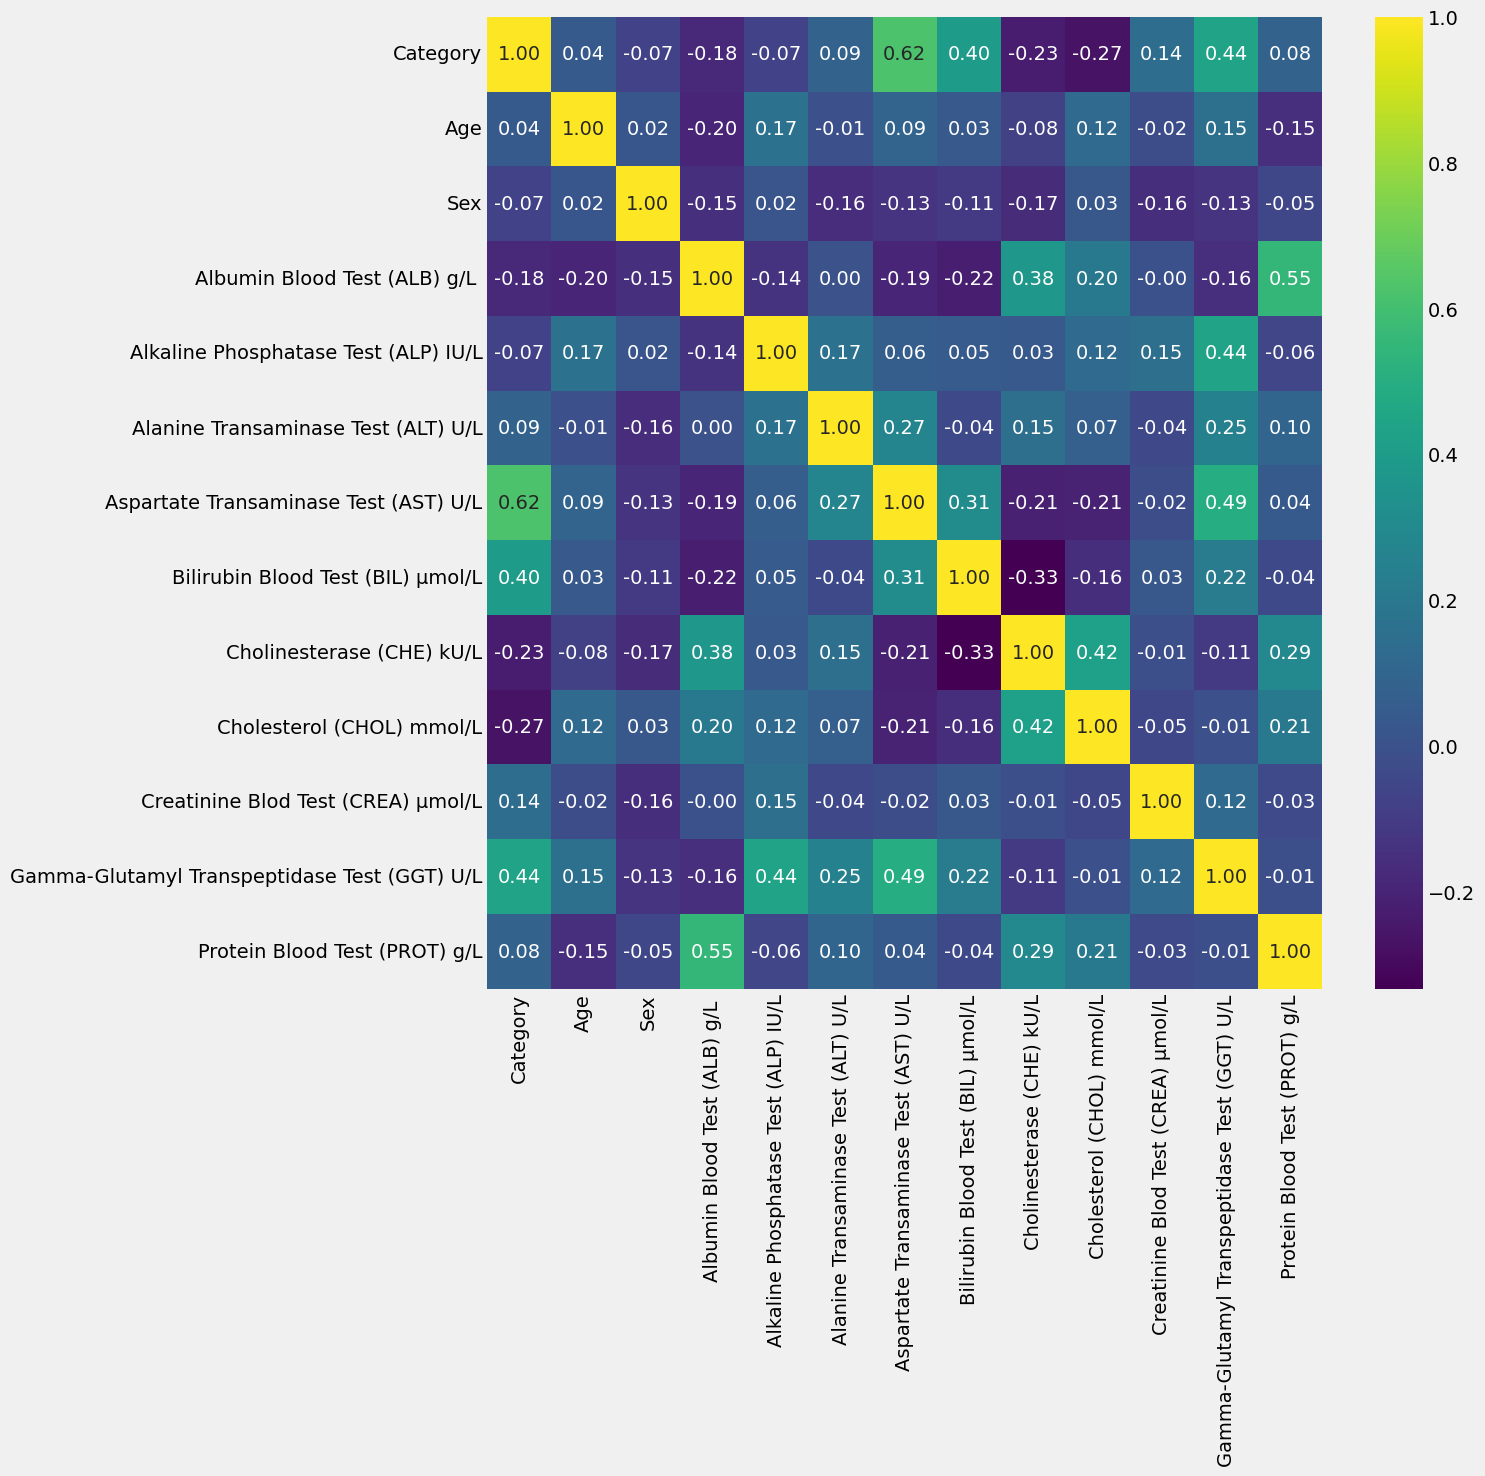

In [ ]:
#Colerration check.
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 12))
sns.heatmap(data.corr(),annot=True,fmt = ".2f",cmap='viridis')
plt.show()

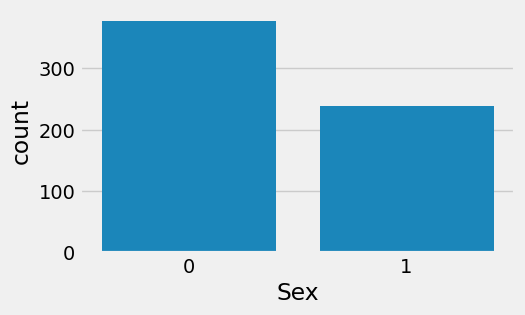

In [ ]:
#Sex
plt.figure(figsize=(5,3))
sns.countplot(x='Sex', data=data)
plt.show()

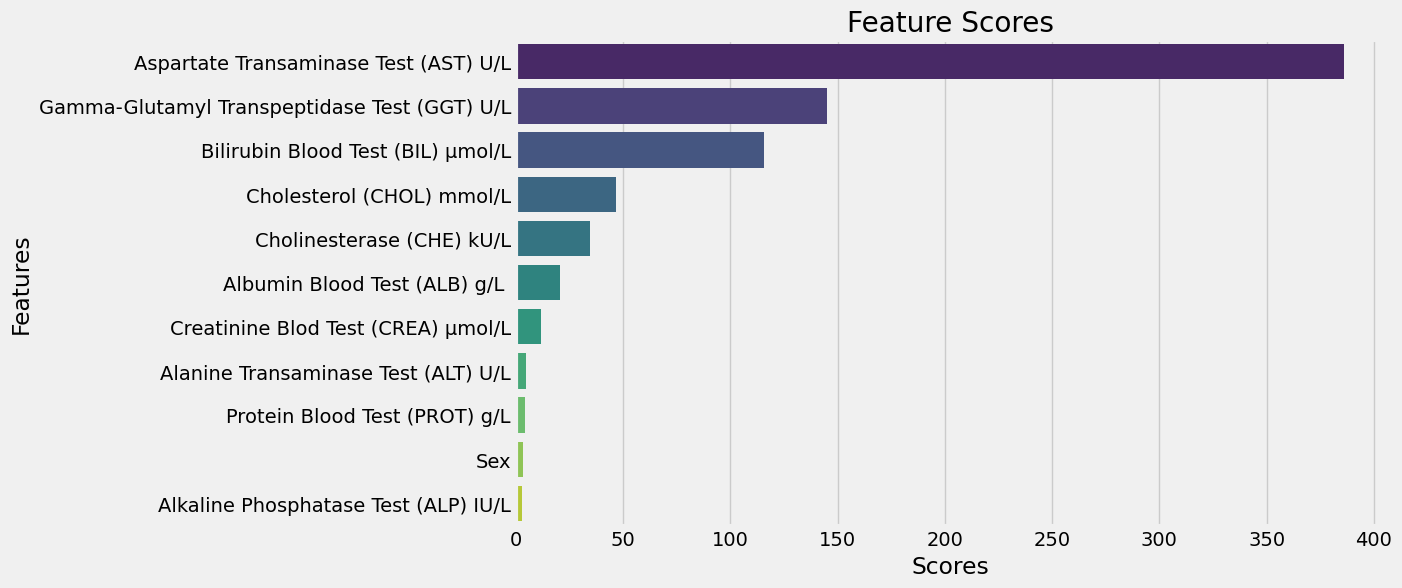

In [ ]:
# Feature selection using SelectKBest with ANOVA F-value
X = data.drop(["Category"], axis = 1)
y = data["Category"]
selector = SelectKBest(f_classif, k=11)
X_selected = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
feature_scores = selector.scores_[selector.get_support()]

# Create a DataFrame to store the feature names and their scores
feature_scores_data_set = pd.DataFrame({'Features': selected_features, 'Scores': feature_scores})

# Sort the DataFrame by score in descending order
feature_scores_data_set = feature_scores_data_set.sort_values(by='Scores', ascending=False)

# Plot the feature scores
plt.figure(figsize=(10, 6))
sns.barplot(x='Scores', y='Features', data=feature_scores_data_set, palette='viridis')
plt.title('Feature Scores')
plt.xlabel('Scores')
plt.ylabel('Features')
plt.show()

In [ ]:
#Features selection
X = X.drop(["Albumin Blood Test (ALB) g/L "], axis = 1)

In [ ]:
#Splitting the data into the training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
clf_rnf=RandomForestClassifier( random_state =46)
parametrs_rnf={'n_estimators':[3,5,7,10], 'max_depth':[2,3,4,5,6]}
grid_forest=GridSearchCV(clf_rnf, parametrs_rnf, cv=6, n_jobs=-1)
grid_forest.fit(X_train,y_train)

GridSearchCV(cv=6, estimator=RandomForestClassifier(random_state=46), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6],
                         'n_estimators': [3, 5, 7, 10]})

In [ ]:
best_model_rnf=grid_forest.best_estimator_
y_pred_rnf=best_model_rnf.predict(X_test)

In [ ]:
print("Random Forest Best parameters: ", grid_forest.best_params_)

Random Forest Best parameters:  {'max_depth': 5, 'n_estimators': 10}


In [ ]:
ac_rnf = accuracy_score(y_test, y_pred_rnf)
print("Accuracy score for model " f'{best_model_rnf} : ',ac_rnf)
cr_rnf = classification_report(y_test, y_pred_rnf)
print("classification_report for model " f'{best_model_rnf} : \n',cr_rnf)

Accuracy score for model RandomForestClassifier(max_depth=5, n_estimators=10, random_state=46) :  0.9513513513513514
classification_report for model RandomForestClassifier(max_depth=5, n_estimators=10, random_state=46) : 
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       156
           1       1.00      0.69      0.82        29

    accuracy                           0.95       185
   macro avg       0.97      0.84      0.89       185
weighted avg       0.95      0.95      0.95       185



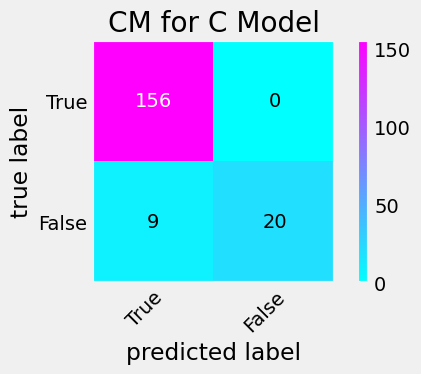

In [ ]:
cm_rnf = confusion_matrix(y_test, y_pred_rnf)
fig, ax = plot_confusion_matrix(conf_mat=cm_rnf ,
                                show_absolute=True,
                                colorbar=True,
                                cmap='cool',
                               class_names = [True , False ],
                               figsize=(5, 3))
plt.title("CM for C Model")
plt.show()